# Pre processing data

In [1]:
#!pip install pandas
import pandas as pd
import csv

#### Changing the delimiter from ',' to ';'

In [2]:
with open('data.csv', 'r') as input_file, open('data_all.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=';')
    for line in input_file:
        line = line.strip()
        
        last_comma = line.rfind(',')

        if last_comma != -1:
            row = [line[:last_comma], line[last_comma + 1:]]
            
        writer.writerow(row)

#### Importing the data

In [3]:
data_all = pd.read_csv('data_all.csv', sep=';')
data_all.describe()

,ticket_description,expert_id
count,400,400
unique,40,10
top,Les permissions des rôles d'utilisateur ne fon...,expert_8
freq,16,53


#### Normalizing characters (because of invalid characters in french data)

In [4]:
import unicodedata

def normalize_chars(text):
    if isinstance(text, str):
        normalized = unicodedata.normalize('NFKD', text)
        no_diacritics = ''.join(char for char in normalized if not unicodedata.combining(char))
        return no_diacritics
    return text

data_all['ticket_description'] = data_all['ticket_description'].apply(normalize_chars)

data_all.to_csv('data_all_normalized.csv', sep=';', index=False)

#### Check for null values

In [5]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ticket_description  400 non-null    object
 1   expert_id           400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


#### Check validity of values

In [6]:
import re

def check_row(row):
    c1 = len(row['ticket_description'].strip()) > 0
    c2 = bool(re.match(r'^expert_\d+$', row['expert_id']))
    return c1 and c2

data_all_cleaned = data_all[data_all.apply(check_row, axis=1)]

data_all = data_all_cleaned.reset_index(drop=True)

data_all.describe()

,ticket_description,expert_id
count,400,400
unique,40,10
top,Les permissions des roles d'utilisateur ne fon...,expert_8
freq,16,53


#### Change the label type from string to integer (out of simplicity, since expert ids are integers)

In [7]:
for i,row in data_all.iterrows():
    data_all.at[i, 'expert_id'] = int(data_all.at[i, 'expert_id'].split('_')[1])
data_all.head()

,ticket_description,expert_id
0,Data not syncing with the cloud.,6
1,System reports inaccurate metrics.,4
2,Payment gateway timeout error.,5
3,Permissions issue for user roles.,0
4,Integration with third-party API fails.,5


#### Splitting the data into english and french parts

In [8]:
num_eng = 200

data_eng = data_all.iloc[:num_eng]
data_fr = data_all.iloc[num_eng:]

data_eng.to_csv('data_1_eng.csv', sep=';', index=False)
data_fr.to_csv('data_1_fr.csv', sep=';', index=False)

#### Analyzing the distribution

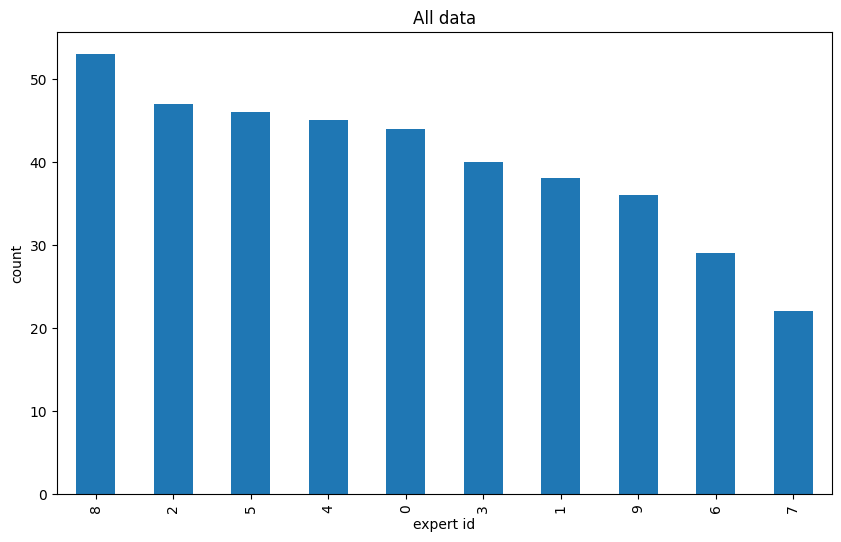

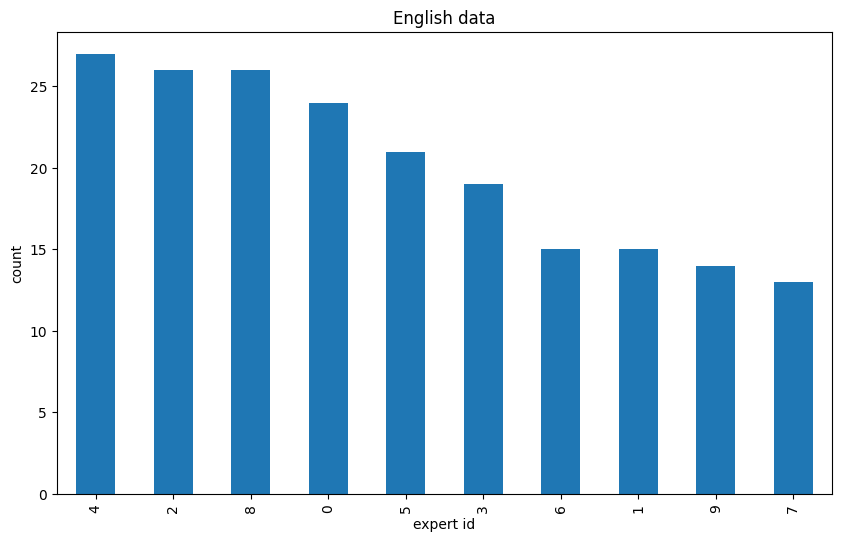

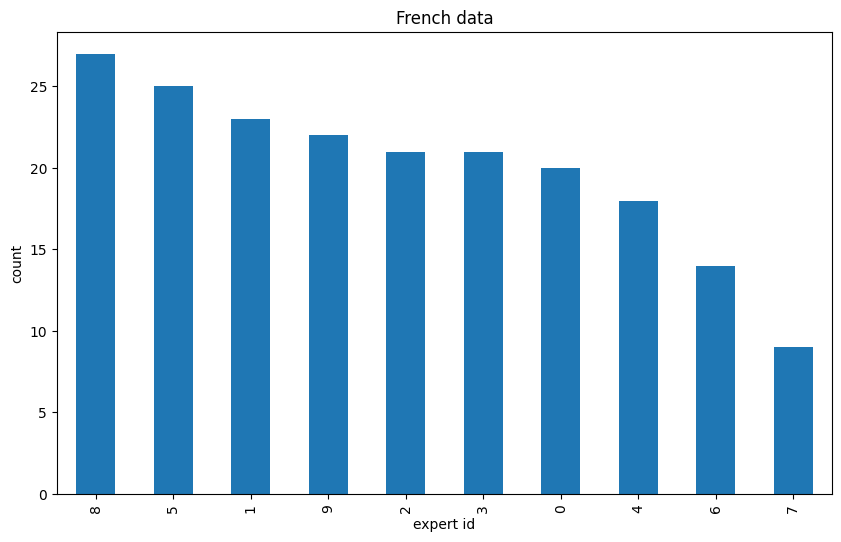

In [9]:
#!pip install matplotlib
import matplotlib.pyplot as plt

distributions = [
    (data_all['expert_id'].value_counts(), 'All data'),
    (data_eng['expert_id'].value_counts(), 'English data'),
    (data_fr['expert_id'].value_counts(), 'French data')
]

for dist, title in distributions:
    dist.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('expert id')
    plt.ylabel('count')
    plt.show()

#### There is a significance difference in distribution between the highest and the lowest frequent classes, but overall, the data is not highly imbalanced

#### APPROACH 1: Removing the duplicates

##### In the first approach, this task was concidered to be a multi-class classification problem where each sentance belongs to only one label. Therefore, the duplicates represent redundant data which can influence overfitting and that's why we remove it

In [10]:
data_1_all = data_all.drop_duplicates()
data_1_eng = data_eng.drop_duplicates()
data_1_fr = data_fr.drop_duplicates()
print(data_1_all.describe())
print(data_1_eng.describe())
print(data_1_fr.describe())

                                       ticket_description  expert_id
count                                                 250        250
unique                                                 40         10
top     Le planificateur n'execute pas les taches prog...          0
freq                                                    9         30
                         ticket_description  expert_id
count                                   124        124
unique                                   20         10
top     Application fails to save settings.          0
freq                                      8         16
                                       ticket_description  expert_id
count                                                 126        126
unique                                                 20         10
top     Le systeme genere des metriques inexactes dans...          8
freq                                                    9         16


#### APPROACH 2: Soft label encoding

##### In the second approach, this task is concidered to be a multi-label classification problem, where sentances do not belong to exclusively one class. Sentances can be completed by different experts and all of the provided data is useful. Instead of having multiple sentances with single labels, we group the sentances and assign labels of the all experts that were assigned to each sentance. This is label encoding, but instead of it being binary, we use soft labels where values are not 1s and 0s, but are actually float values in range [0,1], indicating the frequency of assigned experts

In [11]:
def encode_labels(data):
    result_rows = []
    
    # iterating through unique sentances
    for ticket_description in data['ticket_description'].unique():
        # filtering rows
        filtered_rows = data[data['ticket_description'] == ticket_description]
        
        # calculating the expert frequency
        frequency = filtered_rows['expert_id'].value_counts(normalize=True).reindex(range(num_classes), fill_value=0)
        expert_ids_str = ','.join(map(lambda x: f"{x:.3f}", frequency.values))
        
        # appending the results
        result_rows.append({
            'ticket_description': ticket_description,
            'expert_ids': expert_ids_str
        })
    
    return pd.DataFrame(result_rows)

num_classes = data_all['expert_id'].nunique()

data_2_all = encode_labels(data_all)
data_2_eng = encode_labels(data_eng)
data_2_fr = encode_labels(data_fr)

data_2_eng.to_csv('data_2_all.csv', sep=';', index=False)
data_2_eng.to_csv('data_2_eng.csv', sep=';', index=False)
data_2_fr.to_csv('data_2_fr.csv', sep=';', index=False)

# First model: Traditional vectorization with Naive Bayes and Logistic Legression

#### The traditional model was initially done with the first approach: multi-class classification, while the second advanced model was done also with the second apporach of multi-label classification

#### Data splitting

##### Since the first approach is mutli-class classification, we will perform the classical splitting of data into train, valid and test sets. Since we do not have a lot of data and we would like to evaluate all of the classes (experts), we will make sure to have at least one instance of each class in all three data splits. Since input data is not large, we will manually make sure to have the right ratio of splits (we cannot count on creating splits by comparing ratios to a random number)

In [12]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

def assign_train_valid_test_split(df, class_column, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1, random_seed=None):
    # checking the sum of all ratios
    assert (train_ratio + valid_ratio + test_ratio) == 1.0

    # creating dataframes for splits
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # iterating through all the classes and grouping rows
    for class_label, group in df.groupby(class_column):
        # shuffling the group
        group = group.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # calculating the sizes
        train_size = int(len(group) * train_ratio)
        valid_size = int(len(group) * valid_ratio)

        # make sure to have at least one instance in each split
        train_size = max(train_size, 1)
        valid_size = max(valid_size, 1)
        test_size = max(len(group) - train_size - valid_size, 1)

        # adjust sizes
        while train_size + valid_size + test_size > len(group):
            if train_size > valid_size and train_size > test_size:
                train_size -= 1
            elif valid_size > test_size:
                valid_size -= 1
            else:
                test_size -= 1

        # splitting the group
        train_split = group[:train_size]
        valid_split = group[train_size:train_size + valid_size]
        test_split = group[train_size + valid_size:]

        # appending the data
        train_data = pd.concat([train_data, train_split], ignore_index=True)
        valid_data = pd.concat([valid_data, valid_split], ignore_index=True)
        test_data = pd.concat([test_data, test_split], ignore_index=True)

    # shuffling final splits
    train_data = train_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    valid_data = valid_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    test_data = test_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # adding a split column
    train_data['split'] = 'train'
    valid_data['split'] = 'valid'
    test_data['split'] = 'test'

    # combine all splits into a single dataframe for simplicity
    final_df = pd.concat([train_data, valid_data, test_data], ignore_index=True)

    return final_df

data_all = assign_train_valid_test_split(data_all, random_seed=1, class_column='expert_id')
data_eng = assign_train_valid_test_split(data_eng, random_seed=1, class_column='expert_id')
data_fr = assign_train_valid_test_split(data_fr, random_seed=1, class_column='expert_id')

##### Inspecting to make sure the ratios are approapriate

In [13]:
print(data_all.value_counts('split', normalize=True))
print(data_eng.value_counts('split', normalize=True))
print(data_fr.value_counts('split', normalize=True))

split
train    0.7900
test     0.1225
valid    0.0875
Name: proportion, dtype: float64
split
train    0.780
test     0.145
valid    0.075
Name: proportion, dtype: float64
split
train    0.780
test     0.135
valid    0.085
Name: proportion, dtype: float64


##### Making sure all of the classes are present in all three splits

In [14]:
print(len(data_eng[data_eng['split']=='train'].expert_id.unique()))
print(len(data_eng[data_eng['split']=='valid'].expert_id.unique()))
print(len(data_eng[data_eng['split']=='test'].expert_id.unique()))

print(len(data_all[data_all['split']=='train'].expert_id.unique()))
print(len(data_all[data_all['split']=='valid'].expert_id.unique()))
print(len(data_all[data_all['split']=='test'].expert_id.unique()))

10
10
10
10
10
10


##### In the second approach, since the sentances are grouped and unique, if we split the data into training, valid and test sets, a significant part of the data would not used in the training and therefore not learned on, which we want to avoid since we do not have a lot of data. Instead of splitting, we will use nested k fold cross validation to make sure we use all of the unique data during training and evaluating the model

#### Vectorizing

In [15]:
#!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

##### Since the chosen models Naive Bayes and Logistic Regression require numerical features, we use a simple and effiicent TF-IDF vectorization to convert sentances into numbers, by measuering words importance in sentances and their uniquenes across all sentances  

In [16]:
def get_tfidf_vectors_and_labels(df, vectorizer, split="train", include_valid=False):
    # in case we want to use valid split for training or testing
    if include_valid:
        combined_data = df[df.split.isin([split, "valid"])]
    else:
        combined_data = df[df.split == split]
    # fitting the vectorizer
    if split == "train":
        vectorizer.fit(combined_data['ticket_description'])
    # transforming sentances into numbers
    vectors = vectorizer.transform(combined_data['ticket_description'])
    # attaching the labels
    labels = combined_data['expert_id']
    
    return vectors.toarray(), labels.to_numpy(dtype=int), vectorizer

#### Training

##### The training and predicting is performed with either Naive Bayes or Logistic Regression. The models are similar in complexity, where Naive Bayes chooses the class based on probabilites of words belonging to that class, while logistci regression learns the words contributions to sentance's class

In [17]:
from sklearn.metrics import f1_score, classification_report

def do_tfidf_prediction(df, max_features, model='Naive Bayes'):
    # initializing vectorizer with given number of features
    vectorizer = TfidfVectorizer(max_features=max_features)
    # getting the numerical transformations
    # here, because of model's simplicity and small data, we will include valid split into training
    vectors_train, labels_train, vectorizer = get_tfidf_vectors_and_labels(df, split="train", vectorizer=vectorizer, include_valid=True)
    vectors_test, labels_test, _ = get_tfidf_vectors_and_labels(df, split="test", vectorizer=vectorizer)
    
    # training naive bayes or logistic regression model
    if model == 'Naive Bayes':
        classifier = MultinomialNB().fit(vectors_train, labels_train)
    else:
        classifier = LogisticRegression().fit(vectors_train, labels_train)
    
    # predictions
    predicted_train = classifier.predict(vectors_train)
    predicted_test = classifier.predict(vectors_test)
    
    # overall f1 scores, macro since classes are not exactly evenly distributed
    f1_train = f1_score(labels_train, predicted_train, average='macro')
    f1_test = f1_score(labels_test, predicted_test, average='macro')
    
    return f1_train, f1_test, vectorizer, classifier


##### Inspecting results for a fixed size of max_features

In [18]:
f1_train, f1_test, _, _ = do_tfidf_prediction(data_all, max_features = 10)
f1_train, f1_test

(0.11772011123907462, 0.03305322128851541)

#### Evaluating

##### Trying out different number of max_features and plotting their train and test f1 scores. It's performed with both models on three different datasets: english only, french only and all combined

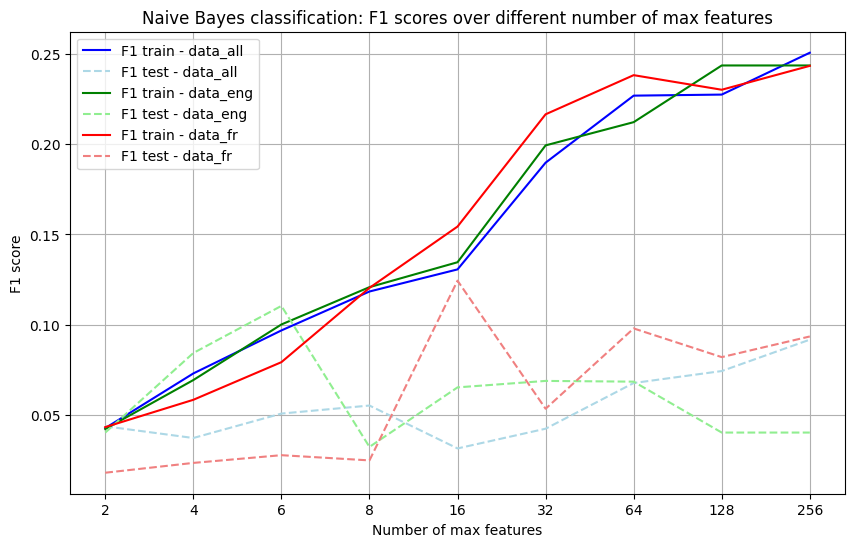

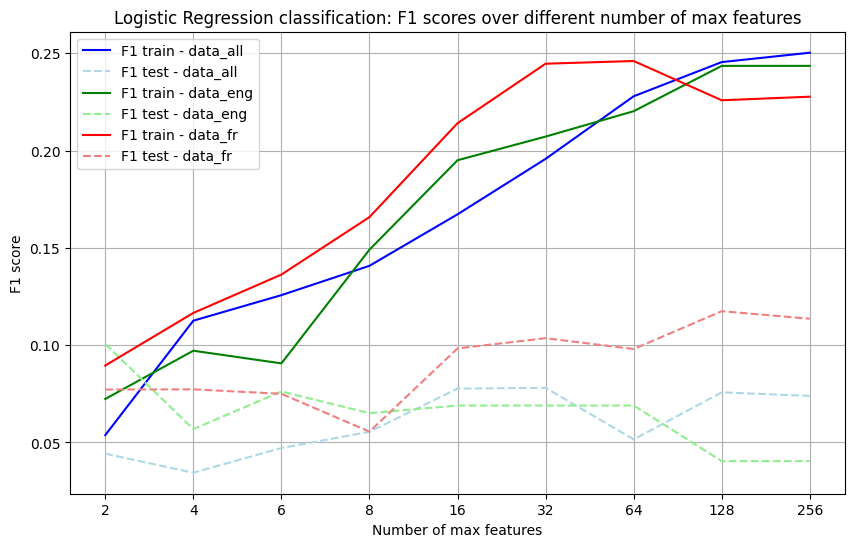

In [19]:
datasets = {
    "data_all": data_all,
    "data_eng": data_eng,
    "data_fr": data_fr
}

# setting different colours for datasets
colors = {
    "data_all": ("blue", "lightblue"),
    "data_eng": ("green", "lightgreen"),
    "data_fr": ("red", "lightcoral")
}

max_features_list = [2, 4, 6, 8, 16, 32, 64, 128, 256]

models = ['Naive Bayes', 'Logistic Regression']

for model_name in models:

    plt.figure(figsize=(10, 6))
    
    # iterating through datasets
    for dataset_name, dataset in datasets.items():
        
        f1_scores_train = []
        f1_scores_test = []
        
        # calculating the f1 scores
        for max_features in max_features_list:
            f1_train, f1_test, _, _ = do_tfidf_prediction(dataset, max_features=max_features, model=model_name)
            f1_scores_train.append(f1_train)
            f1_scores_test.append(f1_test)
        
        # plotting train and test scores
        plt.plot(
            np.arange(len(max_features_list)),
            f1_scores_train,
            label=f"F1 train - {dataset_name}",
            color=colors[dataset_name][0]
        )
        plt.plot(
            np.arange(len(max_features_list)),
            f1_scores_test,
            label=f"F1 test - {dataset_name}",
            color=colors[dataset_name][1],
            linestyle="dashed"
        )
    
    plt.xticks(np.arange(len(max_features_list)), max_features_list)
    plt.xlabel("Number of max features")
    plt.ylabel("F1 score")
    plt.title(f"{model_name} classification: F1 scores over different number of max features")
    plt.legend()
    plt.grid(True)
    
    plt.show()

#### Inference

##### Since the goal of this task is to return top three experts for a sentence in inference, we will convert the predictions into probabilites and return top three of them

In [20]:
def inference_vect(classifier, input_sentence, vectorizer, k=3):
    # vectorizing the input sentance
    input_vector = vectorizer.transform([input_sentence]).toarray()

    # predicting probabilities for all calsses
    if hasattr(classifier, "predict_proba"):
        probs = classifier.predict_proba(input_vector).squeeze()
    else:
        raise ValueError("The provided classifier does not support probability prediction.")
    
    # getting top k predictions
    top_k_indices = np.argsort(probs)[-k:][::-1]
    top_k_classes = [f"class_{i}" for i in top_k_indices]
    top_k_probs = probs[top_k_indices]

    return top_k_classes, top_k_probs

##### Passing a new sentance to the Naive Bayes model with both english and french data, and 256 max features

In [21]:
_, _, vectorizer, classifier = do_tfidf_prediction(data_all, max_features = 256, model='Naive Bayes')

inference_vect(classifier, 'Memory limit exceeded.', vectorizer, k=3)

(['class_5', 'class_0', 'class_6'],
 array([0.1311454 , 0.1305303 , 0.12289652]))

### Conclusion: The multi-class classification approach, where same sentances are assigned different classes, definitely affects the performanse. On top of that, the data set is too small to produce high quality results, specially after removing the duplicates. The large number of classes is also making it harder to learn patterns. The limited data size leads to overfitting on the training set, and poor generalization on the test set. The results are generally poor and similar for all three datasets.

# Second model: BERT

#### BERT is one of the most popular large language models, famous for its fine tuned usages, amongst which is classification of text. For this task, we are using a pret trained version of BERT, called DistilBERT. This model is smaller in size and faster, and is suitable for the small dataset we are using.

#### This model is used for both approaches: multi-class classification, and the multi-label classification, with slightly different cofigurations. Here we are focusing on two different subsets: the english only data and the combined both languages data

##### For the first approach, we split the data into train, valid and test sets, while the second approach will use nested k fold cross validation

In [22]:
x_train_all = data_all[data_all.split=='train']['ticket_description'].values
y_train_all = data_all[data_all.split=='train']['expert_id'].values
x_valid_all = data_all[data_all.split=='valid']['ticket_description'].values
y_valid_all = data_all[data_all.split=='valid']['expert_id'].values
x_test_all = data_all[data_all.split=='test']['ticket_description'].values
y_test_all = data_all[data_all.split=='test']['expert_id'].values


x_train_eng = data_eng[data_eng.split=='train']['ticket_description'].values
y_train_eng = data_eng[data_eng.split=='train']['expert_id'].values
x_valid_eng = data_eng[data_eng.split=='valid']['ticket_description'].values
y_valid_eng = data_eng[data_eng.split=='valid']['expert_id'].values
x_test_eng = data_eng[data_eng.split=='test']['ticket_description'].values
y_test_eng = data_eng[data_eng.split=='test']['expert_id'].values

### Tokenizer

##### Since BERT is a tranformer architecture, it requires the input text to be tokenized. Here we are introducing two different tokenizers, one for english data and the other one for multilingual, becasue of the presence of french language. MAX_LEN is calculated in order to use less than default 512 tokens, for efficiency, since the sentances in our data are much small than that

In [23]:
#!pip install transformersa
from transformers import DistilBertTokenizer

MAX_LEN = 0

tokenizer_eng = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', padding=True, truncation=True)
tokenizer_all = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased', padding=True, truncation=True)

# combining all data to find the max tokens size
all_data = np.concatenate((x_train_all, x_valid_all, x_test_all))

# calculating the max tokens length and inspecting the tokenizer output
for i in range(len(all_data)):
    if len(tokenizer_eng(all_data[i])['input_ids']) > MAX_LEN:
        MAX_LEN = len(tokenizer_eng(all_data[i])['input_ids'])
    if i == 0:
        # tokenize sentences
        tokenizer_out = tokenizer_eng(all_data[i])
        # convert numerical tokens to alphabetical tokens
        encoded_tok = tokenizer_eng.convert_ids_to_tokens(tokenizer_out.input_ids)
        # decode tokens back to string
        decoded = tokenizer_eng.decode(tokenizer_out.input_ids)
        print(tokenizer_out)
        print('\n')
        print(encoded_tok, '\n')
        print('\n')
        print(decoded, '\n')
        print('\n')
        print('---------------- \n')

# multiplied by 2, to allow twice longter sentances in inference
MAX_LEN = MAX_LEN * 2
MAX_LEN

C:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'input_ids': [101, 2543, 9628, 5991, 4646, 4026, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


['[CLS]', 'fire', '##wall', 'blocks', 'application', 'traffic', '.', '[SEP]'] 



[CLS] firewall blocks application traffic. [SEP] 



---------------- 



72

### Custom dataset

##### Creating a custom dataset class which will be used by other tools during training and evaluating

In [24]:
#!pip3 install torch torchvision torchaudio
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len, soft_labels=False):
        self.sentences = sentences
        # Can be either hard or soft labels
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.soft_labels = soft_labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        # returns sentance and its label(s)
        sentence = str(self.sentences[item])
        label = self.labels[item]

        # tokenize the sentence
        tokenizer_out = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # handle soft labels for second approach
        if self.soft_labels:
            # convert the soft labels into right format
            label_tensor = torch.tensor(
                list(map(float, label.split(','))), dtype=torch.float
            )
        else:
            # convert the hard labels
            label_tensor = torch.tensor(label, dtype=torch.long)

        # return a dictionary of outputs
        return {
            'input_ids': tokenizer_out['input_ids'].flatten(),
            'attention_mask': tokenizer_out['attention_mask'].flatten(),
            'label': label_tensor
        }


# for first approach
train_dataset_all = MyDataset(x_train_all, y_train_all, tokenizer_all, MAX_LEN)
valid_dataset_all = MyDataset(x_valid_all, y_valid_all, tokenizer_all, MAX_LEN)
test_dataset_all = MyDataset(x_test_all, y_test_all, tokenizer_all, MAX_LEN)

train_dataset_eng = MyDataset(x_train_eng, y_train_eng, tokenizer_eng, MAX_LEN)
valid_dataset_eng = MyDataset(x_valid_eng, y_valid_eng, tokenizer_eng, MAX_LEN)
test_dataset_eng = MyDataset(x_test_eng, y_test_eng, tokenizer_eng, MAX_LEN)

# for second approach
dataset_2_all = MyDataset(
    data_2_all['ticket_description'].values,
    data_2_all['expert_ids'].values,
    tokenizer_all,
    MAX_LEN,
    soft_labels=True
)
dataset_2_eng = MyDataset(
    data_2_eng['ticket_description'].values,
    data_2_eng['expert_ids'].values,
    tokenizer_eng,
    MAX_LEN,
    soft_labels=True
)

##### Inspect the output shape of the dataset

In [25]:
train_dataset_all[0]

{'input_ids': tensor([  101, 16011, 33743, 47352, 19800, 26482,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'label': tensor(4)}

### Building the model

##### Importing the models

In [26]:
from transformers import DistilBertModel

PRE_TRAINED_MODEL_NAME_ENG = 'distilbert-base-uncased'
PRE_TRAINED_MODEL_NAME_ALL = 'distilbert-base-multilingual-cased'


distil_bert_eng = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME_ENG)
distil_bert_all = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME_ALL)
print(distil_bert_eng)
print(distil_bert_all)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

##### Inspecting output and shape of the model

In [27]:
first_sample = train_dataset_eng[0]
hidden_state = distil_bert_eng(first_sample['input_ids'].unsqueeze(0), attention_mask=first_sample['attention_mask'].unsqueeze(0))
hidden_state[0].shape

torch.Size([1, 72, 768])

#### Building the classifier

##### The pretrained BERT model is used as a parent class for our custom class which represents the fine tuned model. In order to perform classifications, we need to create an output layer which will continue on the output of the parent model encoder. We put a simple linear layer which acts as a classifier, by transforming the dimensions of the encoder's output to the number of unique classes in this task. These outputs are raw logits and are later transformed into probabilities when calculating the losses. Dropout of 10% is used on the encoder's output for regularization. The loss functions differ for the two approaches. The soft labeled approach is using KL Divergence Loss, whcih is comparing the probability distributions of true and predicted labels, while the first approach is using Cross Entropy Loss on the predicted hard labels of the batch and the true ones. The encoder output we are using here is contained in the 0th token, which represents the special CLS token in the transformer architecture and it contains information such as the sentiment of the sentance

In [28]:
from transformers import DistilBertPreTrainedModel, DistilBertConfig

# used for freezing the model parameters during fine tuning
FREEZE_PRETRAINED_MODEL = True

class DistilBertForSentimentClassification(DistilBertPreTrainedModel):
    def __init__(self, pretrained_model_name, config, num_labels, freeze_encoder=False, soft_labels=False):
        super().__init__(config)
        self.num_labels = num_labels
        self.soft_labels = soft_labels
        # iload a pretrained DistilBERT model as encoder
        self.encoder = DistilBertModel.from_pretrained(pretrained_model_name)
        # freeze the parameters
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # classifier layer
        self.classifier = torch.nn.Linear(
            in_features=config.dim, out_features=self.num_labels, bias=True
        )
        # usage of small dropout for regularization
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        # encoding a batch of sequences
        encoder_output = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        # extract the hidden state from the output
        hidden_state = encoder_output[0] # (bs, seq_len, dim)
        # only select the encoding corresponding to the first token (CLS)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        # apply dropout
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        # feed into the classifier
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        outputs = (logits,) + encoder_output[1:]

        # compute loss
        if labels is not None:
            if self.soft_labels:
                # use KLDivLoss for soft labels
                loss_function = torch.nn.KLDivLoss(reduction="batchmean")
                logits = torch.nn.functional.log_softmax(logits, dim=-1)
                loss = loss_function(logits, labels)
            else:
                # use CrossEntropyLoss for hard labels
                loss_function = torch.nn.CrossEntropyLoss()
                loss = loss_function(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)



classes = data_all.expert_id.unique().tolist()

# create the models

# first approach
model_eng_only = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ENG,
    config=distil_bert_eng.config,
    num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
)

model_all = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ALL,
    config=distil_bert_all.config,
    num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
)

##### Choosing the device for training

In [29]:
if torch.cuda.is_available():
    print('GPU will be used.')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('CPU will be used.')

CPU will be used.


### Training and evaluation

#### First approach

##### We are using the Trainer class to handle the training of the model. We are initializing it for both datasets: english only and combined. Parameters such as learning rate, batch size, number of epochs and weight decay are defined here. The binary evaluation metrics are also passed to the Trainer: accuracy, precision, recall and f1 are also passed to the Trainer class for evaluation.

In [30]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist()
    }

training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    logging_first_step=True,
    logging_steps=20,
    num_train_epochs=16,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    learning_rate=1e-4,
    weight_decay=0.01
)

trainer_eng_only = Trainer(
    model=model_eng_only,
    args=training_args,
    train_dataset=train_dataset_eng,
    eval_dataset=valid_dataset_eng,
    compute_metrics=compute_metrics
)
trainer_all = Trainer(
    model=model_all,
    args=training_args,
    train_dataset=train_dataset_all,
    eval_dataset=valid_dataset_all,
    compute_metrics=compute_metrics
)

##### Execution of training

In [31]:
trainer_eng_only.train()
trainer_all.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.314600,2.342511,0.133333,"[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.2857142857142857, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0]"
2,2.293400,2.325679,0.066667,"[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,2.259400,2.315276,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,2.287100,2.310107,0.066667,"[0.0, 0.0, 0.0, 0.0, 0.18181818181818182, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,2.271100,2.309044,0.133333,"[0.0, 0.0, 0.0, 0.0, 0.18181818181818182, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0]"
6,2.248100,2.306098,0.066667,"[0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,2.245100,2.304898,0.133333,"[0.0, 0.0, 0.0, 0.0, 0.18181818181818182, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0]"
8,2.237500,2.303114,0.133333,"[0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0]"
9,2.247900,2.301908,0.133333,"[0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0]"
10,2.237600,2.301284,0.133333,"[0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.5, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0]"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.295500,2.300529,0.171429,"[0.0, 0.0, 0.0, 0.32, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.19047619047619047, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,2.301500,2.287256,0.200000,"[0.0, 0.0, 0.0, 0.2, 0.3333333333333333, 0.4444444444444444, 0.0, 0.0, 0.13333333333333333, 0.0]","[0.0, 0.0, 0.0, 0.16666666666666666, 0.21428571428571427, 0.4, 0.0, 0.0, 0.1, 0.0]","[0.0, 0.0, 0.0, 0.25, 0.75, 0.5, 0.0, 0.0, 0.2, 0.0]"
3,2.272700,2.281674,0.171429,"[0.0, 0.0, 0.0, 0.2, 0.36363636363636365, 0.4, 0.0, 0.0, 0.10526315789473684, 0.0]","[0.0, 0.0, 0.0, 0.16666666666666666, 0.2857142857142857, 0.3333333333333333, 0.0, 0.0, 0.07142857142857142, 0.0]","[0.0, 0.0, 0.0, 0.25, 0.5, 0.5, 0.0, 0.0, 0.2, 0.0]"
4,2.246300,2.277365,0.171429,"[0.0, 0.0, 0.0, 0.2857142857142857, 0.2857142857142857, 0.4, 0.0, 0.0, 0.10526315789473684, 0.0]","[0.0, 0.0, 0.0, 0.3333333333333333, 0.2, 0.3333333333333333, 0.0, 0.0, 0.07142857142857142, 0.0]","[0.0, 0.0, 0.0, 0.25, 0.5, 0.5, 0.0, 0.0, 0.2, 0.0]"
5,2.251300,2.275478,0.200000,"[0.0, 0.0, 0.0, 0.2857142857142857, 0.5, 0.4, 0.0, 0.0, 0.19047619047619047, 0.0]","[0.0, 0.0, 0.0, 0.3333333333333333, 0.5, 0.3333333333333333, 0.0, 0.0, 0.125, 0.0]","[0.0, 0.0, 0.0, 0.25, 0.5, 0.5, 0.0, 0.0, 0.4, 0.0]"
6,2.264400,2.274962,0.085714,"[0.0, 0.0, 0.0, 0.2857142857142857, 0.0, 0.25, 0.0, 0.0, 0.11764705882352941, 0.0]","[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.25, 0.0, 0.0, 0.08333333333333333, 0.0]","[0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.0, 0.2, 0.0]"
7,2.298800,2.273968,0.085714,"[0.0, 0.0, 0.0, 0.2857142857142857, 0.0, 0.25, 0.0, 0.0, 0.11764705882352941, 0.0]","[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.25, 0.0, 0.0, 0.08333333333333333, 0.0]","[0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.0, 0.2, 0.0]"
8,2.257200,2.274157,0.057143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.11764705882352941, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.08333333333333333, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.2, 0.0]"
9,2.270900,2.273896,0.085714,"[0.0, 0.0, 0.0, 0.2857142857142857, 0.0, 0.25, 0.0, 0.0, 0.11764705882352941, 0.0]","[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.25, 0.0, 0.0, 0.08333333333333333, 0.0]","[0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.0, 0.2, 0.0]"
10,2.264100,2.273124,0.085714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.36363636363636365, 0.0, 0.0, 0.11764705882352941, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, 0.0, 0.0, 0.08333333333333333, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.2, 0.0]"


TrainOutput(global_step=640, training_loss=2.2671729266643523, metrics={'train_runtime': 104.6262, 'train_samples_per_second': 48.324, 'train_steps_per_second': 6.117, 'total_flos': 92907791271936.0, 'train_loss': 2.2671729266643523, 'epoch': 16.0})

##### Plotting of the training and validation losses

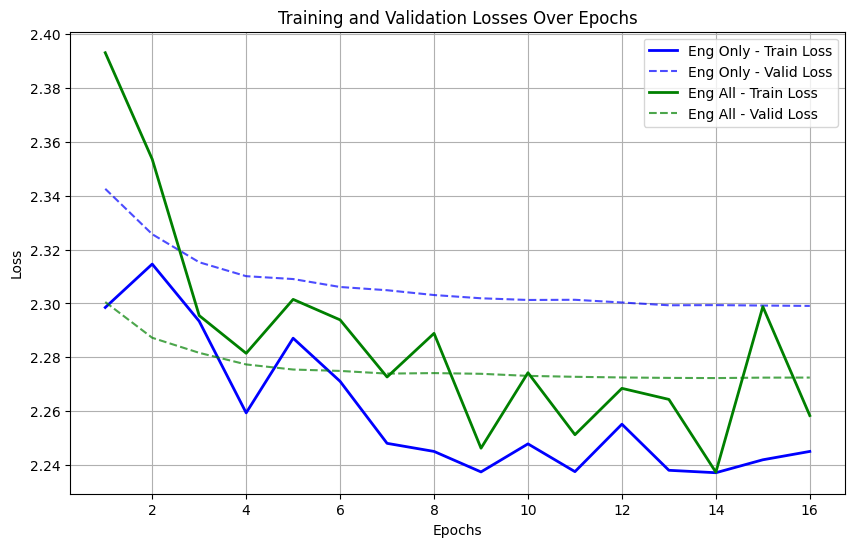

In [32]:
def plot_losses(trainers, labels, colors):
    plt.figure(figsize=(10, 6))

    for trainer, label, color in zip(trainers, labels, colors):
        # extract the log history
        log_history = trainer.state.log_history

        # filter train losses
        train_losses = [
            entry['loss'] for entry in log_history 
            if 'loss' in entry and 'epoch' in entry
        ]
        # filter valid losses
        eval_losses = [
            entry['eval_loss'] for entry in log_history 
            if 'eval_loss' in entry
        ]

        # make sure the lengths match
        min_length = min(len(train_losses), len(eval_losses))
        train_losses = train_losses[:min_length]
        eval_losses = eval_losses[:min_length]

        # x axis for epochs
        epochs = range(1, min_length + 1)

        plt.plot(epochs, train_losses, label=f"{label} - Train Loss", color=color, linewidth=2)
        plt.plot(epochs, eval_losses, label=f"{label} - Valid Loss", color=color, linestyle='dashed', alpha=0.7)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_losses(
    trainers=[trainer_eng_only, trainer_all],
    labels=["Eng Only", "Eng All", "All"],
    colors=["blue", "green", "red"]
)

##### The training and validation losses are similar for both english only and both language models. The loss values are high and indicate poor performance, which can be the result of several factors, such as the size of the data, hyper parameters and also the possibly wrnong apporach of multi-class classification. The losses are lowering, showing that the model is improving over time. The flunctiations are much bigger in the training loss, which is the consencuence of updating parameters after each batch and adjusting to its data. The english only model showed to be slightly better, even though its using less data, possibly becasue it contains only one language. The overall performance for both models is poor, which is also reflected by the output evaluation metrics for each epoch. This can potentially be improved by fine tuning the learning rate, number of epochs, batch sizes and weight decay hyper parameters

#### Evaluation

##### Predicting the labels for the test set

In [33]:
test_results_eng_only = trainer_eng_only.predict(test_dataset=test_dataset_eng)
test_results_all = trainer_all.predict(test_dataset=test_dataset_all)

##### Plotting the f1 scores of the test results per class

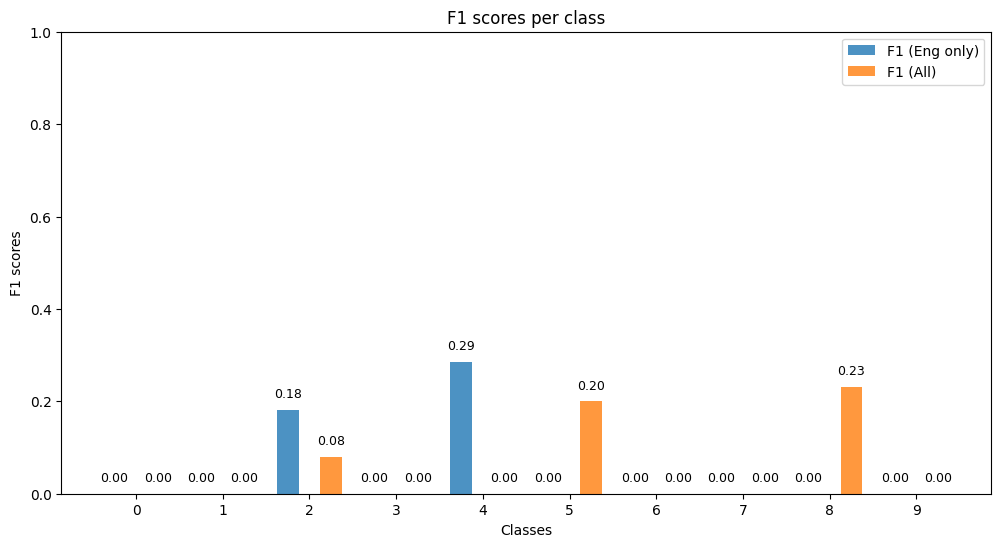

In [34]:
import numpy as np
import matplotlib.pyplot as plt

f1_scores_eng_only = test_results_eng_only.metrics["test_f1"]
f1_scores_all = test_results_all.metrics["test_f1"]

# x axis for classes
x = np.arange(num_classes)
width = 0.25

# plotting the scores
plt.figure(figsize=(12, 6))
bars_eng_only = plt.bar(x - width, f1_scores_eng_only, width, label='F1 (Eng only)', alpha=0.8)
bars_all = plt.bar(x + width, f1_scores_all, width, label='F1 (All)', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('F1 scores')
plt.title('F1 scores per class')
plt.ylim(0, 1)
plt.xticks(ticks=x, labels=range(num_classes))
plt.legend()

for bars in [bars_eng_only, bars_all]:
        for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=9
        )

plt.show()


##### The produced per class f1 scores are very sparse, showing results for only few classes. This is due to the fact that the model has poor performance but also that test set is small and the number of classes which had correct prediction is also small. All of the classes with scores of 0 have not been predicted correctly even once. One observation is that the class for expert_8 had a high score, and is also the most distributed class in the data set, which creates the possibility that the model was slightly more biased for this class

#### Second approach training

##### In the second approach, we are not using classical train,valid,test splits of the data and therefore will not use the Trainer class as in the first approach. We will create our own implemnetation of the training algorithm following the nested k fold cross validation approach. The goal of this is to use the most out of our limited data, since we grouped all of the input sentances by their uniqueness and we want to make sure we use all of them in the training as well as in the evaluating of the model. The precision metric used here is precision@k, which is comparing the rankings of class probabilities in predictions and true labels. This is used to give insight in the performance based on the goal of this task, which is predicting top three experts.

In [35]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

def precision_at_k(preds, labels, k):
    # getting indices of top k probabilities
    top_k_preds = np.argsort(preds, axis=-1)[:, -k:]
    top_k_labels = np.argsort(labels, axis=-1)[:, -k:]

    precision = 0

    # iterating through indices
    for i, (pred_indices, true_indices) in enumerate(zip(top_k_preds, top_k_labels)):
        # create rank mapping for true indices
        true_ranks = {idx: rank for rank, idx in enumerate(reversed(true_indices))}

        matched = 0
        for rank, pred_idx in enumerate(reversed(pred_indices)):  # Reverse for highest rank (closest to the top)
            # concider correctly predicted top k indices
            if pred_idx in true_indices:
                # penalize by the difference in rank
                rank_penalty = 1 / (abs(true_ranks[pred_idx] - rank) + 1)
                matched += rank_penalty

        # normalize the values
        precision += matched / k

    # return the average
    return precision / len(preds)

def nested_k_fold_training(outer_split, inner_split, model_constructor, dataset, learning_rate, weight_decay, num_epochs):
    # create outer k fold splits
    outer_kf = KFold(n_splits=outer_split, shuffle=True, random_state=1)
    
    results = []
    precisions = []

    # outer folds, where data is split into train_val and test parts
    for outer_fold, (train_val_idx, test_idx) in enumerate(outer_kf.split(dataset)):
        
        print(f"Outer Fold {outer_fold + 1}")

        # always start with a new model in outer fold
        model = model_constructor()
    
        # split the data for inner fold and test evaluation
        train_val_dataset = Subset(dataset, train_val_idx)
        test_dataset = Subset(dataset, test_idx)

        # create inner k fold splits
        inner_kf = KFold(n_splits=inner_split, shuffle=True, random_state=1)

        # keep track of the best model to return
        best_model = None
        best_score = float('inf')

        # inner folds, where data is split into train and valid parts
        for inner_fold, (train_idx, val_idx) in enumerate(inner_kf.split(train_val_dataset)):
            
            print(f"  Inner Fold {inner_fold + 1}")
    
            # split the data for training and validation
            train_dataset = Subset(train_val_dataset, train_idx)
            val_dataset = Subset(train_val_dataset, val_idx)
    
            train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=8)
    
            optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
            # training loop
            model.train()
            for epoch in range(num_epochs):
                train_loss = 0
                for batch in train_loader:
                    optimizer.zero_grad()
                    # pass data to model and get outputs
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['label']
                    )
                    # get the loss
                    loss = outputs[0]
                    train_loss += loss.item()
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                avg_train_loss = train_loss / len(train_loader)
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
            
            # validation loop
            model.eval()
            val_loss = 0
            val_preds, val_labels = [], []

            # disable parameter updating
            with torch.no_grad():
                for batch in val_loader:
                    # pass data to model and get outputs
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['label']
                    )
                    # get the loss
                    loss = outputs[0]
                    val_loss += loss.item()
                    # get the logits for precision calculation
                    logits = outputs[1]
                    # apply softmax to get log probabilities
                    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
                        
                    # collect predictions and labels for precision calculation
                    val_preds.append(log_probs.exp().cpu().numpy())
                    val_labels.append(batch['label'].cpu().numpy())
            
            # average the validation loss
            val_loss /= len(val_loader)
            # convert to right format
            val_preds = np.vstack(val_preds)
            val_labels = np.vstack(val_labels)
            # calculate precision
            prec_at_k = precision_at_k(val_preds, val_labels, k=3)
            print(f"    Validation Loss: {val_loss:.4f}, Precision@K: {prec_at_k:.4f}")
    
            # keep track of the best model
            if val_loss < best_score:
                best_score = val_loss
                best_model = model
    
        # evaluate the model on outer fold test data
        test_loader = DataLoader(test_dataset, batch_size=8)
        test_loss = 0
        test_preds, test_labels = [], []
        # disable parameter updating
        with torch.no_grad():
            for batch in test_loader:
                # pass data to model and get outputs
                outputs = best_model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['label']
                )
                # get the loss
                loss = outputs[0]
                test_loss += loss.item()
                 # get the logits for precision calculation
                logits = outputs[1]
                # apply softmax to get log probabilities
                log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
                # collect predictions and labels for precision calculation
                test_preds.append(log_probs.exp().cpu().numpy())
                test_labels.append(batch['label'].cpu().numpy())
        
        # average the test loss
        test_loss /= len(test_loader)
        # convert to right format
        test_preds = np.vstack(test_preds)
        test_labels = np.vstack(test_labels)
        # calculate precision
        prec_at_k = precision_at_k(test_preds, test_labels, k=3)
        precisions.append(prec_at_k)
        print(f"  Test Loss (Outer Fold {outer_fold + 1}): {test_loss:.4f}, Precision@K: {prec_at_k:.4f}")
        results.append(test_loss)
        
    # final evaluation
    average_test_loss = np.mean(results)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    average_prec_at_k = np.mean(precisions)
    print(f"Average Precision@K: {average_prec_at_k:.4f}")

    return best_model


In [36]:
# used to create a new instance of model for nested k fold cross validation
def model_constructor(pretrained_model_name, config, num_labels, freeze_encoder, soft_labels):
    return DistilBertForSentimentClassification(
        pretrained_model_name=pretrained_model_name,
        config=config,
        num_labels=num_labels,
        freeze_encoder=freeze_encoder,
        soft_labels=soft_labels
    )

##### Initialization of models and training

In [37]:
model_2_trained_eng = nested_k_fold_training(
    outer_split=5,
    inner_split=5,
    model_constructor=lambda: model_constructor(
        pretrained_model_name=PRE_TRAINED_MODEL_NAME_ENG,
        config=distil_bert_eng.config,
        num_labels=len(classes),
        freeze_encoder=True,
        soft_labels=True
    ),
    dataset=dataset_2_eng,
    learning_rate=1e-4,
    num_epochs=16,
    weight_decay=0.01
)

Outer Fold 1
  Inner Fold 1
Epoch 1/16, Train Loss: 0.6443
Epoch 2/16, Train Loss: 0.6502
Epoch 3/16, Train Loss: 0.6021
Epoch 4/16, Train Loss: 0.6422
Epoch 5/16, Train Loss: 0.6105
Epoch 6/16, Train Loss: 0.6119
Epoch 7/16, Train Loss: 0.6034
Epoch 8/16, Train Loss: 0.5852
Epoch 9/16, Train Loss: 0.5802
Epoch 10/16, Train Loss: 0.6033
Epoch 11/16, Train Loss: 0.5573
Epoch 12/16, Train Loss: 0.5509
Epoch 13/16, Train Loss: 0.5616
Epoch 14/16, Train Loss: 0.5531
Epoch 15/16, Train Loss: 0.5631
Epoch 16/16, Train Loss: 0.5324
    Validation Loss: 0.4985, Precision@K: 0.2222
  Inner Fold 2
Epoch 1/16, Train Loss: 0.5276
Epoch 2/16, Train Loss: 0.5280
Epoch 3/16, Train Loss: 0.5351
Epoch 4/16, Train Loss: 0.5126
Epoch 5/16, Train Loss: 0.5132
Epoch 6/16, Train Loss: 0.5445
Epoch 7/16, Train Loss: 0.5051
Epoch 8/16, Train Loss: 0.5147
Epoch 9/16, Train Loss: 0.5063
Epoch 10/16, Train Loss: 0.4908
Epoch 11/16, Train Loss: 0.5093
Epoch 12/16, Train Loss: 0.5160
Epoch 13/16, Train Loss: 0.453

In [38]:
model_2_trained_all = nested_k_fold_training(
    outer_split=5,
    inner_split=5,
    model_constructor=lambda: model_constructor(
        pretrained_model_name=PRE_TRAINED_MODEL_NAME_ALL,
        config=distil_bert_all.config,
        num_labels=len(classes),
        freeze_encoder=True,
        soft_labels=True
    ),
    dataset=dataset_2_all,
    learning_rate=1e-4,
    weight_decay=0.01,
    num_epochs=16
)

Outer Fold 1
  Inner Fold 1
Epoch 1/16, Train Loss: 0.5485
Epoch 2/16, Train Loss: 0.5987
Epoch 3/16, Train Loss: 0.5881
Epoch 4/16, Train Loss: 0.5307
Epoch 5/16, Train Loss: 0.5695
Epoch 6/16, Train Loss: 0.5068
Epoch 7/16, Train Loss: 0.5909
Epoch 8/16, Train Loss: 0.5291
Epoch 9/16, Train Loss: 0.5327
Epoch 10/16, Train Loss: 0.4709
Epoch 11/16, Train Loss: 0.5009
Epoch 12/16, Train Loss: 0.4964
Epoch 13/16, Train Loss: 0.5610
Epoch 14/16, Train Loss: 0.4630
Epoch 15/16, Train Loss: 0.5008
Epoch 16/16, Train Loss: 0.4904
    Validation Loss: 0.7448, Precision@K: 0.1825
  Inner Fold 2
Epoch 1/16, Train Loss: 0.4958
Epoch 2/16, Train Loss: 0.6162
Epoch 3/16, Train Loss: 0.5117
Epoch 4/16, Train Loss: 0.5577
Epoch 5/16, Train Loss: 0.4938
Epoch 6/16, Train Loss: 0.5536
Epoch 7/16, Train Loss: 0.5768
Epoch 8/16, Train Loss: 0.4984
Epoch 9/16, Train Loss: 0.4814
Epoch 10/16, Train Loss: 0.4791
Epoch 11/16, Train Loss: 0.4576
Epoch 12/16, Train Loss: 0.5632
Epoch 13/16, Train Loss: 0.616

##### The results of the english only and both language models are once again very similar. The final averages show that these model have similar losses as well as precisions with their rankings. These train and valid losses are significatnly smaller than those of the first approach, but are calculated in a different way so this is not meaningful. Overall, the results are poor which could be a consenquence of the already mentioned dataset limitations as well as the initial non fine tuned hyper parameters

### Inference

##### Since the goal of this task is to output top three experts for a ticket description, we will use already trained models and return their top 3 predicted probabilities for expert classes

In [39]:
def inference_bert(model, input_sentance, tokenizer, device, k):
    # tokenizing the sentance
    input_tokens = tokenizer(input_sentance, return_tensors='pt').to(device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
         # passing the sentance and returning the logits

        
        #logits = model(**input_tokens).output[1]
        logits = model(
            input_ids=input_tokens['input_ids'],
            attention_mask=input_tokens['attention_mask']
        )[0]
        
        # transforming into probabilities
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        probs = log_probs.exp()
        # getting the top k
        top_k_probs, top_k_indeces = torch.topk(logits, k=k, dim=1)
        top_k_experts = [f'expert_{i}' for i in top_k_indeces.squeeze().tolist()]
    
    return top_k_experts, top_k_probs.squeeze().tolist()

##### Manual check of classes

In [40]:
sentence_class_dict = (
    pd.read_csv('data_all.csv', sep=';')
    .groupby('ticket_description')['expert_id']
    .value_counts()
    .groupby(level=0)
    .apply(lambda x: list(zip(x.index.get_level_values(1), x.values)))
    .to_dict()
)

##### We will use the true labels form our dataset for these two sentances and visually compare them to what our models are outputting. Also, we will provide them with new sentances, with similar key words to "Data not syncing with the cloud." and "Error 404 when accessing the application.", so see if they will return similar experts as these

In [41]:
print(sentence_class_dict["Data not syncing with the cloud."])
print(sentence_class_dict["Error 404 when accessing the application."])

[('expert_2', 2), ('expert_8', 2), ('expert_0', 1), ('expert_5', 1), ('expert_6', 1), ('expert_7', 1)]
[('expert_7', 3), ('expert_9', 3), ('expert_2', 2), ('expert_5', 2), ('expert_6', 2), ('expert_0', 1), ('expert_4', 1)]


##### Vectorization models

In [42]:
_, _, vectorizer_bayes, classifier_bayes = do_tfidf_prediction(data_all, max_features = 256, model='Naive Bayes')
_, _, vectorizer_logistic, classifier_logistic = do_tfidf_prediction(data_all, max_features = 256, model='Logistic')

In [43]:
# new sentances
print("new")
print(inference_vect(classifier_bayes, 'Cloud error regarding data sync.', vectorizer_bayes, k=3))
print(inference_vect(classifier_bayes, 'Application access returns 404.', vectorizer_bayes, k=3))

# old sentances
print("old")
print(inference_vect(classifier_bayes, 'Data not syncing with the cloud.', vectorizer_bayes, k=3))
print(inference_vect(classifier_bayes, 'Error 404 when accessing the application.', vectorizer_bayes, k=3))

print()

# new sentances
print("new")
print(inference_vect(classifier_logistic, 'Cloud error regarding data sync.', vectorizer_logistic, k=3))
print(inference_vect(classifier_logistic, 'Application access returns 404.', vectorizer_logistic, k=3))

# old sentances
print("old")
print(inference_vect(classifier_logistic, 'Data not syncing with the cloud.', vectorizer_logistic, k=3))
print(inference_vect(classifier_logistic, 'Error 404 when accessing the application.', vectorizer_logistic, k=3))

new
(['class_2', 'class_8', 'class_0'], array([0.18271958, 0.15574134, 0.12895185]))
(['class_4', 'class_8', 'class_2'], array([0.16748103, 0.15953274, 0.13364847]))
old
(['class_2', 'class_8', 'class_5'], array([0.23656008, 0.18355121, 0.119714  ]))
(['class_5', 'class_2', 'class_4'], array([0.1669718 , 0.14997842, 0.14265775]))

new
(['class_8', 'class_2', 'class_0'], array([0.15215256, 0.15149754, 0.13095092]))
(['class_4', 'class_8', 'class_2'], array([0.1647941 , 0.14333503, 0.13329366]))
old
(['class_2', 'class_8', 'class_5'], array([0.19787854, 0.17948809, 0.11627695]))
(['class_5', 'class_2', 'class_4'], array([0.14906846, 0.13900373, 0.13532382]))


##### BERT First approach

In [44]:
# new sentances
print("new")
print(inference_bert(model_all, "Cloud error regarding data sync.", tokenizer_all, device, k=3))
print(inference_bert(model_all, "Application access returns 404.", tokenizer_all, device, k=3))

# old sentances
print("old")
print(inference_bert(model_all, "Data not syncing with the cloud.", tokenizer_all, device, k=3))
print(inference_bert(model_all, "Error 404 when accessing the application.", tokenizer_all, device, k=3))

print()

# new sentances
print("new")
print(inference_bert(model_eng_only, "Cloud error regarding data sync.", tokenizer_eng, device, k=3))
print(inference_bert(model_eng_only, "Application access returns 404.", tokenizer_eng, device, k=3))

# old sentances
print("old")
print(inference_bert(model_eng_only, "Data not syncing with the cloud.", tokenizer_eng, device, k=3))
print(inference_bert(model_eng_only, "Error 404 when accessing the application.", tokenizer_eng, device, k=3))

new
(['expert_2', 'expert_4', 'expert_8'], [0.21784040331840515, 0.17881357669830322, 0.11214935779571533])
(['expert_4', 'expert_2', 'expert_8'], [0.2733030617237091, 0.2089579999446869, 0.20189838111400604])
old
(['expert_2', 'expert_8', 'expert_4'], [0.1767909675836563, 0.12201175093650818, 0.108925960958004])
(['expert_2', 'expert_8', 'expert_0'], [0.1987890899181366, 0.16601543128490448, 0.06459085643291473])

new
(['expert_2', 'expert_4', 'expert_0'], [0.3447420001029968, 0.2634940445423126, 0.177247554063797])
(['expert_4', 'expert_2', 'expert_5'], [0.2954951822757721, 0.21484707295894623, 0.1436472237110138])
old
(['expert_0', 'expert_2', 'expert_4'], [0.21205021440982819, 0.19652873277664185, 0.1549534648656845])
(['expert_2', 'expert_4', 'expert_8'], [0.32616883516311646, 0.31080198287963867, 0.13888615369796753])


##### BERT Second approach

In [45]:
# new sentances
print("new")
print(inference_bert(model_2_trained_all, "Cloud error regarding data sync.", tokenizer_all, device, k=3))
print(inference_bert(model_2_trained_all, "Application access returns 404.", tokenizer_all, device, k=3))

# old sentances
print("old")
print(inference_bert(model_2_trained_all, "Data not syncing with the cloud.", tokenizer_all, device, k=3))
print(inference_bert(model_2_trained_all, "Error 404 when accessing the application.", tokenizer_all, device, k=3))

print()

# new sentance
print("new")
print(inference_bert(model_2_trained_eng, "Cloud error regarding data sync.", tokenizer_eng, device, k=3))
print(inference_bert(model_2_trained_eng, "Application access returns 404.", tokenizer_eng, device, k=3))

# old sentances
print("old")
print(inference_bert(model_2_trained_eng, "Data not syncing with the cloud.", tokenizer_eng, device, k=3))
print(inference_bert(model_2_trained_eng, "Error 404 when accessing the application.", tokenizer_eng, device, k=3))

new
(['expert_4', 'expert_0', 'expert_8'], [0.6433902978897095, 0.22902728617191315, 0.17955441772937775])
(['expert_4', 'expert_0', 'expert_8'], [0.6231966614723206, 0.29855334758758545, 0.2281108945608139])
old
(['expert_4', 'expert_0', 'expert_8'], [0.39226704835891724, 0.29382625222206116, 0.2352864146232605])
(['expert_4', 'expert_8', 'expert_3'], [0.4368797242641449, 0.21978406608104706, 0.16806474328041077])

new
(['expert_2', 'expert_0', 'expert_4'], [0.5909643769264221, 0.44338110089302063, 0.39951393008232117])
(['expert_2', 'expert_4', 'expert_3'], [0.751166045665741, 0.5333460569381714, 0.4010883569717407])
old
(['expert_2', 'expert_8', 'expert_0'], [0.7733923196792603, 0.5409674048423767, 0.5092843174934387])
(['expert_2', 'expert_0', 'expert_4'], [0.7070170640945435, 0.4895773231983185, 0.4284771978855133])


##### It appears that all of the models are mostly outputting these classes: 4,8,2,0. This might be becasue their distributions are the amongst the higest in the dataset. The sentance: "Data not syncing with the cloud." is assigned exactly these classes in the dataset, and by just observing the new setance similar to it, it seems like the models are making a good prediction for the experts. However, that is why we added another new sentance similar to: "Error 404 when accessing the application." and we get the experts from the same subset as the first sentance, even though the correct experts from the dataset are totaly different for this sentance.

In [46]:
print(inference_bert(model_2_trained_eng, "Why are you outputting the same classes?", tokenizer_eng, device, k=3))

(['expert_4', 'expert_2', 'expert_3'], [0.575684130191803, 0.5419238209724426, 0.29540565609931946])


##### All of the sentaces and their classes

In [47]:
sentence_class_dict

{'Application fails to save settings.': [('expert_0', 3),
  ('expert_2', 1),
  ('expert_3', 1),
  ('expert_4', 1),
  ('expert_5', 1),
  ('expert_7', 1),
  ('expert_8', 1),
  ('expert_9', 1)],
 'Backup process fails intermittently.': [('expert_1', 3),
  ('expert_3', 2),
  ('expert_8', 2),
  ('expert_0', 1),
  ('expert_2', 1),
  ('expert_4', 1)],
 'Data not syncing with the cloud.': [('expert_2', 2),
  ('expert_8', 2),
  ('expert_0', 1),
  ('expert_5', 1),
  ('expert_6', 1),
  ('expert_7', 1)],
 "Des fuites de mémoire sont observées lors de l'exécution d'opérations intensives ou prolongées.": [('expert_3',
   4),
  ('expert_5', 2),
  ('expert_8', 2),
  ('expert_4', 1),
  ('expert_6', 1),
  ('expert_9', 1)],
 "Déconnexion inattendue du système après une longue période d'inactivité sur l'application.": [('expert_5',
   5),
  ('expert_2', 2),
  ('expert_1', 1),
  ('expert_6', 1),
  ('expert_7', 1)],
 'Email notifications not being sent.': [('expert_2', 2),
  ('expert_0', 1),
  ('expert_3', 

# Final conclusion

The performance of the models in this task is clearly affected by the limitations of the dataset and the complexity of the classification problem. The two approaches: multi-class classification and multi-label classification with soft labels—approach the task differently, each with its own challenges and benefits.

In the first approach, removing duplicate sentences to avoid overfitting reduces the size of the dataset, and the multi-class classification framework struggles with the high number of classes and reassignment of different classes to same sentances. This leads to sparse performance across classes, with many not being predicted correctly even once. The small dataset and hyperparameters further add to the low performance, and even using combined multilingual data doesn’t lead to much improvement over the English-only subset.

The second approach takes advantage of nested k-fold cross-validation to make the most out of the grouped unique data, ensuring every sentence is used for training and evaluation. Using soft labels allows the model to make more meaningful predictions based on expert frequencies, but while the validation and test losses in this approach are lower compared to the first, they aren’t directly comparable due to the different loss functions. Precision metrics remain low, showing that even with these changes, the models still have trouble generalizing well.

A clear bias toward a few dominant classes, like 4, 8, 2, and 0, was observed in the model outputs. This bias sometimes aligns with correct predictions, as with "Data not syncing with the cloud," but it fails when the expected experts belong to less frequent classes, as seen with "Error 404 when accessing the application." This highlights the need to better handle class imbalances and consider alternative training strategies.

The vectorization-based models, Naive Bayes and Logistic Regression, also demonstrated a tendency to favor the same dominant classes (4, 8, 2, and 0). Both models, relying on TF-IDF vectorization to represent sentences as numerical features, showed limited ability to generalize to less frequent classes. 

Overall, the results show how the small dataset, imbalanced distributions, and the challenges of both multi-class and multi-label setups make this task tough for the models. To improve, future efforts could look at fine-tuning hyperparameters more thoroughly, working with larger datasets, or using additional pretraining and fine-tuning strategies.